In [15]:
import time
import numpy as np
from scipy import constants as C
from scipy.special import erf
from numba import jit
from typing import Dict, Tuple, List
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, LogNorm 
import matplotlib.cm as cm

class ParticleSimulator:
    """Simulate the motion of charged particles in a Geomagnetic field and electronic field."""


    # 物理常量 
    q = C.elementary_charge # 基本电荷量 (C)
    Re = 6371e3 # 地球半径 (m)
    c = C.speed_of_light # 光速 (m/s)

    def __init__(
        self,
        input_params: Dict,
        pulse_params_list: List,
        bg_params: Dict,
    ):
        # 参数检查和初始化
        for pulse_params in pulse_params_list:
            self._validate_parameters(input_params, pulse_params, bg_params)
        self.input_params = input_params.copy()
        self.pulse_params_list = pulse_params_list.copy()
        self.bg_params = bg_params.copy()

        # 预计算常量
        self.m0 = self._get_particle_mass()
        self.q = - np.abs(self.q) if self.input_params["xmu"] == -1 else self.q
        self.current_state = {} # 粒子的当前状态，位置，能量，mu，dt

    def _validate_parameters(self, input_params: Dict, pulse_params: Dict, bg_params: Dict):
        """严格的参数校验逻辑"""
        # 定义各参数组的允许键集合
        allowed_keys = {
            "input": {"xmu", 'IOPT', 'raddist0', 'longi0', 'KEc0', 'pa',
                    'timedir', 'Tout', 'Dmin', 'pulse_flag', 'tmax', 'model', 'date'},
            "pulse": {'phi0', 'E0', 'c0', 'c1', 'c2', 'c3', 'p', 'va',
                    'ri', 'ti', 'di', 'rd', 'vpulse', 'duration'},
            "bg": {'phi0', 'E0', 'omega', 'guass_flag', 'random_phi_flag'}
        }

        # 类型校验
        for params, name in zip([input_params, pulse_params, bg_params],
                            ["input_params", "pulse_params", "bg_params"]):
            if not isinstance(params, dict):
                raise TypeError(f"{name} must be a dictionary")

        # 键校验
        self._check_keys(input_params, allowed_keys["input"], "input_params")
        self._check_keys(pulse_params, allowed_keys["pulse"], "pulse_params") 
        self._check_keys(bg_params, allowed_keys["bg"], "bg_params")

        # 关键参数值校验
        if input_params["xmu"] not in (-1, 1):
            raise ValueError("xmu must be -1 (electron) or 1 (proton)")
        if not 1 <= input_params["IOPT"] <= 10:
            raise ValueError("IOPT (KP+1) must be between 1 and 10")
        if input_params["raddist0"] <= 1.0:
            raise ValueError("Initial L-shell (raddist0) must be > 1.0 Re")
        
    def _check_keys(self, params, allowed_keys, params_name):
        """检查输入参数是否符合输入要求"""
        for key, values in params.items():
            if key not in allowed_keys:
                raise ValueError(f"input {params_name} key must in {allowed_keys}")

        
    def _get_particle_mass(self):
        return C.electron_mass if self.input_params["xmu"] == -1 else C.proton_mass
    
    def run_simulation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """"主模拟流程"""

        self.current_state.update(self._initialize_particle())
        trajectory = []
        timestamps = []
        energies = []

        # 记录初始状态
        trajectory.append(self.current_state["position"] / self.Re)
        timestamps.append(self.current_state["time"])
        energies.append(self.current_state["energy"]) 

        while True:
            # 执行一步RK4步进
            new_state = self._rk4_step()  
            # 计算新状态物理量
            # 1. 获取磁场强度
            B_new, E_new = self._compute_fields(new_state["time"], new_state["position"]/self.Re)
            B_mag_new = np.linalg.norm(B_new)
            
            # 根据绝热不变量计算能量
            mu = self.current_state["magnetic_moment"]
            
            # 计算垂直动量
            p_perp = np.sqrt(2 * self.m0 * mu * B_mag_new * abs(self.q))

            # 计算总能量
            total_energy_j = np.sqrt(p_perp**2 * self.c**2 + (self.m0 * self.c**2)**2)
            # 记录新状态

            # 更新状态能量
            new_state["energy"] = total_energy_j

            # 记录轨迹
            trajectory.append(new_state["position"] / self.Re)
            timestamps.append(new_state["time"])
            energies.append(total_energy_j)

            # 检查终止条件
            if self._check_termination(new_state):
                break

            self.current_state = new_state
            # print(self.current_state)

        return np.array(trajectory), np.array(timestamps), np.array(energies)


    def _initialize_particle(self) -> Dict:
        """初始化粒子的物理状态（位置、动量、能量、磁场等）"""
        # 从输入参数获取初始条件
        L = self.input_params["raddist0"]       # 初始L-shell（地球半径倍数）
        phi0_deg = self.input_params["longi0"]  # 初始经度（度）
        pa_deg = self.input_params["pa"]        # 初始投掷角（度）
        KEc0_keV = self.input_params["KEc0"]    # 初始动能（keV）

        # ---- 1. 计算初始位置（磁赤道面直角坐标，单位：Re） ----
        phi0_rad = np.deg2rad(phi0_deg)
        x0 = L * np.cos(phi0_rad)  # X方向（太阳方向）
        y0 = L * np.sin(phi0_rad)  # Y方向（黄昏方向）
        z0 = 0.0                   # 磁赤道面Z=0
        position_re = np.array([x0, y0, z0])  # 位置（Re单位）

        # ---- 2. 计算初始磁场（背景场 + 脉冲场） ----
        B, E = self._compute_fields(t=0.0, position=position_re)
        B_mag = np.linalg.norm(B)  # 磁场强度（nT）
        
        # ---- 3. 计算初始动量（考虑相对论效应） ----
        # 将动能转换为总能量（J）
        kinetic_energy_j = KEc0_keV * 1e3 * C.elementary_charge  # keV -> J
        total_energy_j = kinetic_energy_j + self.m0 * C.c**2

        # 相对论动量计算：E^2 = (pc)^2 + (m0c^2)^2
        p_mag = np.sqrt(total_energy_j**2 - (self.m0 * C.c**2)**2) / C.c  # kg·m/s

        # 投掷角分解动量分量
        pa_rad = np.deg2rad(pa_deg)
        p_perp = p_mag * np.sin(pa_rad)  # 垂直动量
        p_parallel = p_mag * np.cos(pa_rad)  # 平行动量

        # ---- 4. 计算绝热不变量Mr ----
        mu = (p_perp**2) / (2 * self.m0 * B_mag * abs(self.q))  # 单位：eV/nT

        # ---- 5. 计算初始漂移速度和时间步长 ----
        # 调用DERIV方法计算初始漂移速度
        position_m = position_re * self.Re  # 转换为米

        self.current_state.update(
            {
            "position": position_m,       # 初始位置（米）
            "energy": total_energy_j,     # 总能量（焦耳）
            "magnetic_moment": mu,  
            }
        )
        v_drift = self._compute_derivative(position_m, t=0.0)
        v_drift_mag = np.linalg.norm(v_drift)

        # 初始时间步长：保证每步漂移角度变化dphi≈3度
        dphi_deg = 3.0
        dt = (dphi_deg * np.pi/180) * L * self.Re / (v_drift_mag + 1e-16)  # 避免除零

        return {
            "position": position_m,       # 初始位置（米）
            # "momentum": np.array([p_perp, 0.0, p_parallel]),  # 动量分量（假设磁场沿Z方向）
            "energy": total_energy_j,     # 总能量（焦耳）
            "magnetic_moment": mu,        # 绝热不变量（eV/nT）
            "time": 0.0,                  # 初始时间
            "dt": dt,                     # 初始时间步长（秒）
            "magnetic_field": B           # 初始磁场（nT）
        }

    # @jit(nopython=True)
    def _compute_fields(self, t:float, position:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """计算磁场和脉冲电场
        Args:
            t:时间（秒）
            position:粒子位置（Re单位）

        return:
            B:nT
            E:V/m
        """

        # 地球磁场计算（向量化）
        B = np.zeros(3)
        r = np.linalg.norm(position)
        B[2] = 0.311e5 * 1 / r**3

        # 脉冲场计算
        E = np.zeros(3)
        if self.input_params["pulse_flag"]:
            E_pulse, B_pulse = self._compute_pulse_fields(t, position)
            B += B_pulse * 1e9
            E += E_pulse
        return B, E
    
    def _compute_pulse_fields(self, t:float, position:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """计算脉冲电场和磁场
        Args:
            t: 时间（秒）
            position: 粒子位置（Re单位）

        return:
            E_pulse: V/m
            B_pulse: T
        """

        position = position * self.Re # Re转换成m
        E_pulse_total = np.zeros(3) # 初始化总电场脉冲
        B_pulse_total = np.zeros(3) # 初始化总磁场脉冲
        # 参数解包
        for pulse_params in self.pulse_params_list:
            params = pulse_params
            phi0 = params["phi0"]
            phi = np.mod(np.rad2deg(np.arctan2(position[1], position[0])) + 360, 360)
            dphi = np.deg2rad(phi - phi0)
            E0 = params["E0"] * 1e-3 # mV/m -> V/m
            vr = self._compute_pulse_velocity(position, params)
            c0 = params.get("c0")
            c1 = params.get("c1")
            c2 = params.get("c2")
            c3 = params.get("c3")
            p = params.get("p")
            rd = params.get("rd")
            va = params.get("va")
            ri = params.get("ri")
            ti = params.get("ti")
            di = params.get("di")

            # 球坐标单位向量计算(简化)
            r = np.linalg.norm(position)
            er = position / r
            ew = np.array([-position[1], position[0], 0]) / np.hypot(position[0], position[1])
            eu = np.cross(er, ew)

            # 脉冲时空分布计算（向量化）
            t0 = (c3 * self.Re / va) * (1 - np.cos(dphi))
            iexp = (r - ri + vr * (t - t0 - ti)) / di
            rexp= (r - ri - c0 * vr * (t - t0 - ti) - rd * self.Re) / di

            # 电场脉冲
            # EFw 纬向电场
            E0ampl = E0 * (1 + c1 * np.cos(np.deg2rad(phi - phi0)))**p
            EFw = E0ampl * (np.exp(-iexp**2) - c2 * np.exp(-rexp**2))
            E_pulse = -EFw * ew
            E_pulse_total += E_pulse # 累加电场脉冲

            # 磁场脉冲
            # Btheta 经线方向磁场
            dE0ampl = E0 * p * (1 + c1 * np.cos(dphi))**(p-1) # partial differentiation with respect to phis
            dvr = 0 # dv/dr, vpulse=const in this case
            Bu1_in_a = np.exp(-iexp**2)*(1+dvr*(t-t0-ti))/vr
            Bu1_in_b = -(di*np.sqrt(np.pi)*dvr/(2*vr**2))
            Bu1_re_a = np.exp(-rexp**2)*(-1.0+dvr*(t-t0-ti))/vr
            Bu1_re_b = (di*np.sqrt(np.pi)*dvr/(2*c0*vr**2))*(-1+erf(rexp))
            Bu1 = E0ampl * ( (Bu1_in_a + Bu1_in_b) - c2*(Bu1_re_a + Bu1_re_b) )
            Bu2_in = (1+erf(iexp))/(2*r*vr)
            Bu2_re = (-1+erf(rexp))/(2*r*vr)
            Bu2 = E0ampl*di*np.sqrt(np.pi)*(Bu2_in+(c2/c0)*Bu2_re)
            BFu = Bu1+Bu2
            Bu = BFu * eu

            #Brad 径向方向磁场
            Br_in = E0ampl*di*np.sqrt(np.pi)*( -1+erf(iexp))/(2*r*vr)
            Br_re = (c2/c0)*E0ampl*di*np.sqrt(np.pi)*(1+erf(rexp))/(2*r*vr)
            urad = np.arcsin(1)	# equatorial plane: theta = 90 deg
            BFr = -(1/np.tan(urad))*(Br_in + Br_re)
            Br = -BFr  *er
            B_pulse = Bu + Br
            # B_pulse = np.zeros_like(E_pulse)  # 简化磁场计算，暂时不考虑脉冲磁场
            B_pulse_total += B_pulse # 累加磁场脉冲
            
        
        return E_pulse_total, B_pulse_total      
    
    def _compute_pulse_velocity(self, position:np.ndarray, params:Dict) -> float:
        """计算脉冲速度
        Args:
            position: 粒子位置（m）"""
        vpulse = params["vpulse"] # m/s
        if vpulse == 1:
            a = 53.15 * 0.8
            b = 0.0093 * 0.8
            vpulse = a * 1e3 + b * np.linalg.norm(position)
            return vpulse
        else:
            return vpulse
        
    # @jit(nopython=True)    
    def _rk4_step(self)-> Dict:
        """RK4步进(numba加速)"""
        y = self.current_state["position"]
        t = self.current_state["time"]
        dt = self.current_state["dt"]

        # RK4 系数
        k1 = self._compute_derivative(y, t)
        k2 = self._compute_derivative(y + 0.5*dt*k1, t + 0.5*dt)
        k3 = self._compute_derivative(y + 0.5*dt*k2, t + 0.5*dt)
        k4 = self._compute_derivative(y + dt*k3, t + dt)    

        new_y = y + dt *(k1 + 2*k2 + 2*k3 + k4) / 6.0
        new_t = t + dt
        new_B, new_E = self._compute_fields(t=new_t, position=new_y)
        return {
            "position": new_y,
            "time": new_t,
            "energy":self.current_state["energy"],
            "magnetic_moment":self.current_state["magnetic_moment"],
            "dt": self._adapt_time_step(new_y, new_t, dt),
            "magnetic_field":new_B
        }  
    
    # @jit(nopython=True)    
    def _compute_derivative(self, position:np.ndarray, t:float) -> np.ndarray:
        """计算粒子的总漂移速度
        Args:
            position: 粒子位置（米单位）
            t: 时间（秒）"""
        
        # ---- 1. 计算磁场和电场 ----
        B, E = self._compute_fields(t, position/self.Re) # position需转换为Re单位 B: nT, E: V/m

        # ---- 2. 计算磁场梯度（垂直分量） ----
        # 使用perpgradB方法计算垂直梯度
        B_mag = np.linalg.norm(B)
        if B_mag < 1e-15: # 避免磁场为0导致除零 
            return np.zeros(3)
        
        # 获取磁场梯度（单位：nT/Re, 转换为T/m）
        grad_B_perp = self._perpgradB(t, position/self.Re) # 输入位置需转换为Re单位 nT/Re 

        # ---- 3. 计算磁矩μ ----
        # 从当前状态获取动量垂直分量（假设已存储磁矩或动量）
        mu = self.current_state.get("magnetic_moment") # eV/nT
        total_energy_j = self.current_state["energy"] # 总能量（J）
        gamma = total_energy_j / (self.m0 * self.c**2) # Lorentz因子

        # ---- 4. 计算梯度漂移速度 ----
        B_unit = B / B_mag
        grad_B_cross_B = np.cross(grad_B_perp, B_unit)
        vfact = mu * 1/B_mag * 1/gamma * 1/self.Re * 1E9 * self.q / C.elementary_charge
        v_grad = vfact * grad_B_cross_B

        # ---- 5. 计算E×B漂移速度 ----
        B_T = B * 1e-9 # nT -> T
        E_x_B = np.cross(E, B_T)
        v_ExB = E_x_B / (np.linalg.norm(B_T)**2) # m/s

        # ---- 6. 计算总漂移速度 ----
        v_drift_total = v_ExB + v_grad
        
        return v_drift_total
    
    @staticmethod
    @jit(nopython=True)
    def _compute_drift_velocity_static(position, t, magnetic_field, electric_field, magnetic_moment, energy, particle_mass, particle_charge, Re_val, c_val):
        """静态方法计算漂移速度 (jit 优化)"""
        B = magnetic_field
        E = electric_field
        mu = magnetic_moment
        m0 = particle_mass
        q = particle_charge
        Re = Re_val
        c = c_val

        # ---- 2. 计算磁场梯度（垂直分量） ----
        B_mag = np.linalg.norm(B)
        if B_mag < 1e-15:
            return np.zeros(3)

        # 这里假设 _perpgradB 也被改造成静态方法
        grad_B_perp = ParticleSimulator._perpgradB_static(t, position/Re, magnetic_field_func=ParticleSimulator._compute_fields_static) # 需要传递计算磁场的函数

        # ---- 3. 计算磁矩μ ---- (mu 已经作为参数传入)
        total_energy_j = energy  # 总能量（J）
        gamma = total_energy_j / (m0 * c**2) # Lorentz因子

        # ---- 4. 计算梯度漂移速度 ----
        B_unit = B / B_mag
        grad_B_cross_B = np.cross(grad_B_perp, B_unit)
        vfact = mu * 1/B_mag * 1/gamma * 1/Re * 1E9 * q / C.elementary_charge
        v_grad = vfact * grad_B_cross_B

        # ---- 5. 计算E×B漂移速度 ----
        B_T = B * 1e-9 # nT -> T
        E_x_B = np.cross(E, B_T)
        v_ExB = E_x_B / (np.linalg.norm(B_T)**2) # m/s

        # ---- 6. 计算总漂移速度 ----
        v_drift_total = v_ExB + v_grad

        return v_drift_total
    
    def _perpgradB(self, t:float, position_re:np.ndarray) -> np.ndarray:
        """计算磁场垂直梯度
        Args:
            t: 时间（秒）
            position_re: 粒子位置（Re单位）"""
        
        # 使用中心差分法计算梯度
        ds = 1e-4 # 步长（Re单位）
        e1, e2, e3 = self.UNITEX(t, position_re, tilt=0.0)

        # 沿e2方向差分
        pos_p = position_re + ds * e2
        B_p = np.linalg.norm(self._compute_fields(t, pos_p)[0])
        
        pos_m = position_re - ds * e2
        B_m = np.linalg.norm(self._compute_fields(t, pos_m)[0])
        
        grad_B_e2 = (B_p - B_m) / (2 * ds)  # nT/Re
        
        # 沿e3方向差分
        pos_p = position_re + ds * e3
        B_p = np.linalg.norm(self._compute_fields(t, pos_p)[0])
        
        pos_m = position_re - ds * e3
        B_m = np.linalg.norm(self._compute_fields(t, pos_m)[0])
        
        grad_B_e3 = (B_p - B_m) / (2 * ds)  # nT/Re
        
        # 合成垂直梯度
        grad_B_perp = grad_B_e2 * e2 + grad_B_e3 * e3
        return grad_B_perp  # 单位：nT/Re
    
    def _adapt_time_step(self, y, t, dt):
        """步长调整程序"""
        dphi_target  = 3 # 目标每步角度变化（度）
        max_factor = 1.1   # 步长最大增长因子
        min_factor = 0.9   # 步长最小减少因子
        dt_min = 1e-3      # 最小时间步长（秒）
        dt_max = 15       # 最大时间步长（秒）

        # 计算当前位置的L-shell（Re单位）
        L_shell = np.linalg.norm(y) / self.Re

        # 计算漂移速度
        v_drift = self._compute_derivative(y, t)
        v_drift_mag = np.linalg.norm(v_drift)

        # 处理极低速度或半径的情况，避免除以零
        if v_drift_mag < 1e-10 or L_shell < 1e-3:
            return max(dt * min_factor, dt_min)
        
        # 计算角度变化（°）
        delta_phi_rad = (v_drift_mag * dt) / (L_shell * self.Re)
        dphi = np.rad2deg(delta_phi_rad)

        # 调整时间步长
        if dphi < 1e-3:
            ratio = max_factor
        else:
            ratio = dphi_target/dphi

        # 限制调整幅度
        ratio = np.clip(ratio, min_factor, max_factor)
        dt_new = dt * ratio   

        # 应用绝对限制
        dt_new = np.clip(dt_new, dt_min, dt_max)     
        return dt_new

    def _check_termination(self, state:Dict) -> bool:
        """检查模拟终止条件"""
        r = np.linalg.norm(state["position"])/self.Re # 单位Re
        
        # 条件1：超过最大模拟时间
        if state["time"] > self.input_params["tmax"] * 60:
            return True
        
        # 条件2：跨越内磁层边界
        if r <= 2.5 or r >=10:
            return True
        
        return False
    
    def UNITEX(self, t:float, position:np.ndarray, tilt:float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """计算磁场方向的单位向量及垂直方向（e2：phi与e1的叉乘）的单位向量
        Args:
            t: 时间（秒）
            position: 粒子位置（Re单位）"""
        
        B, _ = self._compute_fields(t, position)
        B_mag = np.linalg.norm(B)
        if B_mag < 1e-15:
            return np.zeros(3), np.zeros(3), np.zeros(3)
        e1 = B / B_mag # 磁场方向单位向量

        # 计算垂直于磁场的两个正交单位向量
        _, _, ew = self.UNIT_sph(position)
        ew_x_e1 = np.cross(ew, e1)
        e2 = ew_x_e1 / np.linalg.norm(ew_x_e1)

        e3 = np.cross(e1, e2)
        return e1, e2, e3


    def UNIT_sph(self, position:np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """计算球坐标系的单位向量
        Args:
            position: 粒子位置（Re单位）"""
        
        r = np.linalg.norm(position)
        er = position / r
        ew = np.array([-position[1], position[0], 0]) / np.hypot(position[0], position[1])
        eu = np.cross(er, ew)

        return er, eu, ew

    def visualize_fields_equatorial_plane(self, t, x_range_re: tuple = (-10, 10), y_range_re: tuple = (-10, 10),
                                            resolution: int = 50):
        """可视化赤道平面 (z=0) 的电场和磁场分布，用 pcolormesh 显示场强，中间地球左半圆黑色 (夜侧)，右半圆白色 (日侧).

        Args:
            x_range_re (tuple, optional): x 轴范围，以地球半径 Re 为单位. 默认为 (-10, 10).
            y_range_re (tuple, optional): y 轴范围，以地球半径 Re 为单位. 默认为 (-10, 10).
            resolution (int, optional):  网格分辨率. 默认为 50.
        """
        x = np.linspace(x_range_re[0], x_range_re[1], resolution)
        y = np.linspace(y_range_re[0], y_range_re[1], resolution)
        X, Y = np.meshgrid(x, y)
        Ex_values = np.zeros_like(X)
        Ey_values = np.zeros_like(X)
        Ez_values = np.zeros_like(X)
        Bx_values = np.zeros_like(X)
        By_values = np.zeros_like(X)
        Bz_values = np.zeros_like(X)

        for i in range(resolution):
            for j in range(resolution):
                observation_point_re = np.array([X[i, j], Y[i, j], 0])
                B, E = self._compute_fields(t, observation_point_re) # 时间设置为 0，展示静态场
                Ex_values[i, j] = E[0]
                Ey_values[i, j] = E[1]
                Ez_values[i, j] = E[2]
                Bx_values[i, j] = B[0]
                By_values[i, j] = B[1]
                Bz_values[i, j] = B[2]

        # 绘制电场
        plt.figure(figsize=(12, 5))
        ax1 = plt.subplot(1, 2, 1) # 第一个子图：电场
        E_magnitude = np.sqrt(Ex_values**2 + Ey_values**2 + Ez_values**2)
        norm_E = Normalize(vmin=E_magnitude.min(), vmax=E_magnitude.max()) # 电场颜色归一化
        cmap_E = cm.viridis # 电场颜色映射
        mesh_E = ax1.pcolormesh(X, Y, E_magnitude, norm=norm_E, cmap=cmap_E, shading='gouraud') # 使用 pcolormesh
        plt.colorbar(mesh_E, label='Electric Field Magnitude [mV/m]', cmap=cmap_E, norm=norm_E, orientation='vertical', fraction=0.046, pad=0.04) # 电场颜色棒
        # plt.quiver(X, Y, Ex_values / E_magnitude, Ey_values / E_magnitude, color='white', alpha=0.7,  # 删除 quiver 箭头
        #            linewidth=0.5, headwidth=3, headlength=5, headaxislength=4)
        plt.title('Electric Field in Equatorial Plane (Z=0)')
        plt.xlabel('X [Re]')
        plt.ylabel('Y [Re]')
        plt.axis('equal') # 保证 X, Y 轴比例一致

        # 添加地球 (圆形) 到电场图 - 使用 Wedge patches (保持不变)
        left_half_e = patches.Wedge((0, 0), 1, 90, 270, facecolor='black', edgecolor='black',zorder=3)
        right_half_e = patches.Wedge((0, 0), 1, 270, 90, facecolor='white', edgecolor='black',zorder=3)
        ax1.add_patch(left_half_e)
        ax1.add_patch(right_half_e)

        # 绘制磁场
        ax2 = plt.subplot(1, 2, 2) # 第二个子图：磁场
        B_magnitude = np.sqrt(Bx_values**2 + By_values**2 + Bz_values**2)
        # 磁场颜色归一化 - 使用 LogNorm (对数刻度)
        norm_B = LogNorm(vmin=B_magnitude.min(), vmax=B_magnitude.max()) # 磁场颜色归一化 (对数)
        print(norm_B)
        cmap_B = cm.plasma # 磁场颜色映射
        mesh_B = ax2.pcolormesh(X, Y, B_magnitude, norm=norm_B, cmap=cmap_B, shading='gouraud') # 使用 pcolormesh
        plt.colorbar(mesh_B, label='Magnetic Field Magnitude [nT]', cmap=cmap_B, norm=norm_B, orientation='vertical', fraction=0.046, pad=0.04) # 磁场颜色棒
        # plt.quiver(X, Y, Bx_values / B_magnitude, By_values / B_magnitude, color='white', alpha=0.7, # 删除 quiver 箭头
        #            linewidth=0.5, headwidth=3, headlength=5, headaxislength=4)
        plt.title('Magnetic Field in Equatorial Plane (Z=0)')
        plt.xlabel('X [Re]')
        plt.ylabel('Y [Re]')
        plt.axis('equal') # 保证 X, Y 轴比例一致

        # 添加地球 (圆形) 到磁场图 - 使用 Wedge patches (保持不变)
        left_half_b = patches.Wedge((0, 0), 1, 90, 270, facecolor='black', edgecolor='black',zorder=3)
        right_half_b = patches.Wedge((0, 0), 1, 270, 90, facecolor='white', edgecolor='black',zorder=3)
        ax2.add_patch(left_half_b)
        ax2.add_patch(right_half_b)

        plt.tight_layout()
        plt.show()


    def plot_field_time_series(self, observation_point_re: np.ndarray, time_points: np.ndarray,
                                 b_ylim: tuple = None, e_ylim: tuple = None):  # Y 轴范围参数现在是可选的
        """绘制指定观测点电场和磁场随时间变化的线图 (所有分量在同一图中，带图例).

        Args:
            observation_point_re (np.ndarray): 观测点的坐标，以地球半径 Re 为单位.
            time_points (np.ndarray):  要观测的时间点数组.
            b_ylim (tuple, optional): 磁场 Y 轴的数值范围，格式为 (ymin, ymax). 默认为 None，自动调整.
            e_ylim (tuple, optional): 电场 Y 轴的数值范围，格式为 (ymin, ymax). 默认为 None，自动调整.
        """
        # 初始化存储数据的列表
        time_data = []
        Bx_data = []
        By_data = []
        Bz_data = []
        Ex_data = []
        Ey_data = []
        Ez_data = []

        # 遍历时间点，计算并存储每个点的电场和磁场
        for t in time_points:
            B_vec, E_vec = self._compute_fields(t, observation_point_re)

            time_data.append(t)
            Bx_data.append(B_vec[0])
            By_data.append(B_vec[1])
            Bz_data.append(B_vec[2])
            Ex_data.append(E_vec[0])
            Ey_data.append(E_vec[1])
            Ez_data.append(E_vec[2])

        # 绘制线图 (双纵轴，所有分量在一个图中)
        fig, ax1 = plt.subplots(figsize=(12, 6)) # 创建主坐标轴 (用于电场，默认是左侧 Y 轴)

        # 电场分量 (绘制在左侧 Y 轴，颜色用红色)
        line_e_x, = ax1.plot(time_data, Ex_data, label='Ex', color='r', linestyle='-')
        line_e_y, = ax1.plot(time_data, Ey_data, label='Ey', color='r', linestyle='--')
        line_e_z, = ax1.plot(time_data, Ez_data, label='Ez', color='r', linestyle=':')

        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('Electric Field [mV/m]', color='r') # 左侧 Y 轴标签和颜色
        ax1.tick_params(axis='y', labelcolor='r') # 左侧 Y 轴刻度标签颜色

        if e_ylim is not None:
            ax1.set_ylim(e_ylim) # 设置电场 Y 轴范围

        # 创建共享 X 轴的第二个坐标轴，用于磁场 (右侧 Y 轴)
        ax2 = ax1.twinx()

        # 磁场分量 (绘制在右侧 Y 轴，颜色用蓝色)
        line_b_x, = ax2.plot(time_data, Bx_data, label='Bx', color='b', linestyle='-') # 蓝色
        line_b_y, = ax2.plot(time_data, By_data, label='By', color='b', linestyle='--')
        line_b_z, = ax2.plot(time_data, Bz_data, label='Bz', color='b', linestyle=':')

        ax2.set_ylabel('Magnetic Field [nT]', color='b') # 右侧 Y 轴标签和颜色
        ax2.tick_params(axis='y', labelcolor='b') # 右侧 Y 轴刻度标签颜色

        if b_ylim is not None:
            ax2.set_ylim(b_ylim) # 设置磁场 Y 轴范围

        # 合并图例 (将电场和磁场的图例都放在一起)
        lines = [line_e_x, line_e_y, line_e_z, line_b_x, line_b_y, line_b_z]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc='upper right') # 将图例放在右上角，可以根据需要调整位置

        plt.title(f'Electric and Magnetic Field Time Series at ({observation_point_re[0]:.2f}, {observation_point_re[1]:.2f}, {observation_point_re[2]:.2f}) Re')
        ax1.grid(True) # 网格线仍然使用主坐标轴的网格
        plt.tight_layout()
        plt.show()


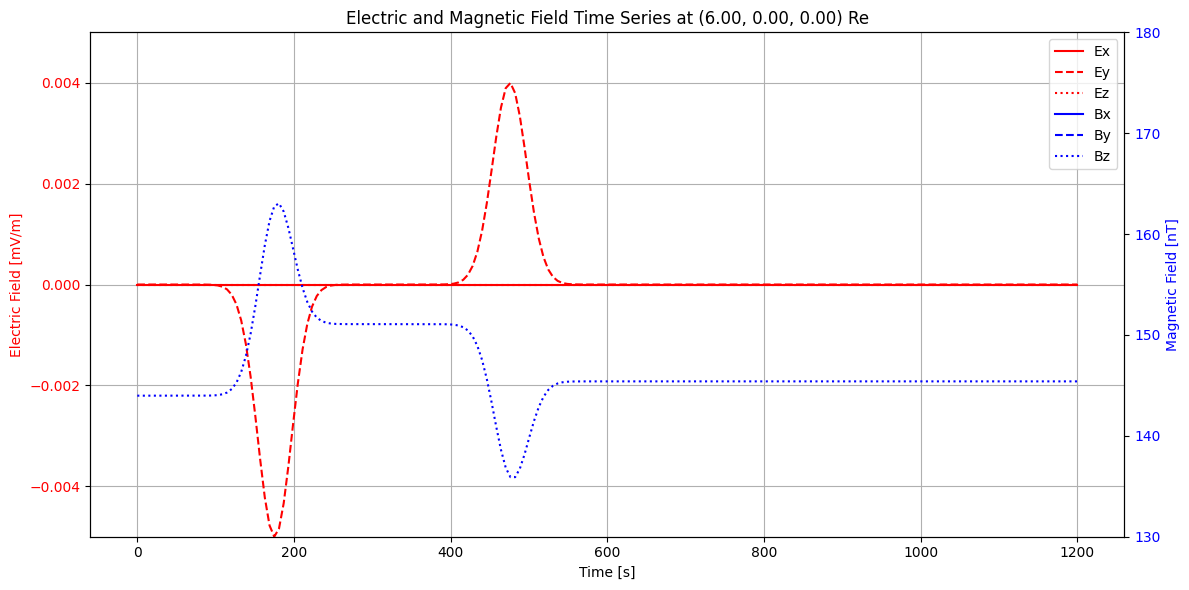

In [24]:
input_params = {
    "xmu": -1, # -1 for electron, 1 for proton
    "IOPT": 1, # = kp + 1
    "raddist0": 6, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": 2000, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 1, 
    "tmax": 20, # maximum simulation time /min
}         
pulse_params_list = [
    {
        "phi0":0,
        "E0": 2.5, # 5mV/m
        "c0":1,
        "c1":1,
        "c2":0,
        "c3":1,
        "p":1,
        "va":50000,
        "ri":0.6371E8 * 1.5, # m ri/vpulse determine the arrival time of pusle
        "ti":0,
        "di":1e7, # width of the pusle
        "rd":2.06, # pulse rebound at rd/2 Re
        "vpulse": 1, # m/s
    },
    {
        "phi0":0,
        "E0": -2, # 5mV/m
        "c0":1,
        "c1":1,
        "c2":0,
        "c3":1,
        "p":1,
        "va":50000,
        "ri":0.6371E8 * 1.5, # m ri/vpulse determine the arrival time of pusle
        "ti":300,
        "di":1e7, # width of the pusle
        "rd":2.06, # pulse rebound at rd/2 Re
        "vpulse": 1, # m/s        
    }
]
p1 = ParticleSimulator(input_params, pulse_params_list, {})
observation_point_re = np.array([6.0, 0.0, 0.0]) 
time_points = np.linspace(0, 1200, 200) # 从 0 到 10 秒，采样 200 个点
p1.plot_field_time_series(observation_point_re, time_points, b_ylim=(130, 180), e_ylim=(-5e-3, 5e-3))


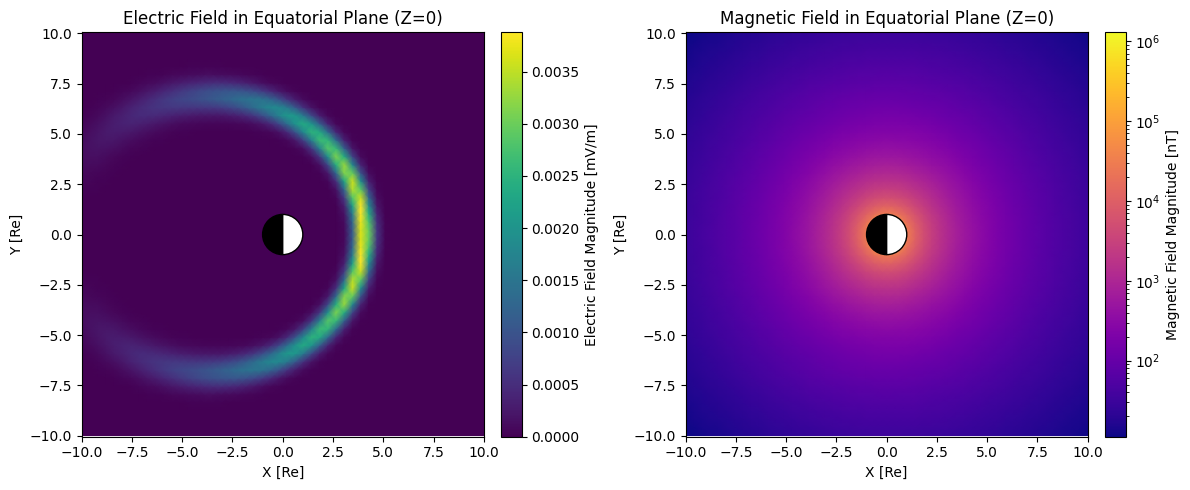

In [4]:
# a = p1.run_simulation()
# x = [i[0] for i in a[0]]
# y = [i[1] for i in a[0]]
# import matplotlib.pyplot as plt
# plt.scatter(x, y)

p1.visualize_fields_equatorial_plane(t=300)